In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.0


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
!unzip /content/gdrive/MyDrive/GAN_datasets/photo2cartoon.zip -d /

In [ ]:
!ls /

In [ ]:
import glob
faces = glob.glob('/trainA/*.jpg')
cartoons = glob.glob("/trainB/*.png")
faces_test = glob.glob('/testA/*.jpg')
cartoons_test = glob.glob('/testB/*.png')

In [3]:
import glob
path = '/Users/k15/Downloads/selfie2anime/'
faces = glob.glob(path + '/trainA/*.jpg')
cartoons = glob.glob(path + "../cartoonset10k/*.png")
faces_test = glob.glob(path + '/testA/*.jpg')

In [4]:
len(faces), len(cartoons), len(faces_test)

(3400, 10000, 100)

In [5]:
import cv2
for file in cartoons[:10]:
    img = cv2.imread(file)
    print (img.shape)

(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)


Human Faces


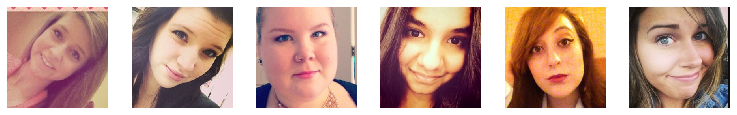

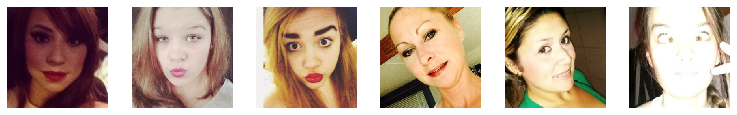

--------------------------------------------------------------------------------
Cartoon Faces


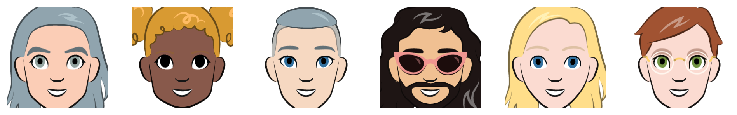

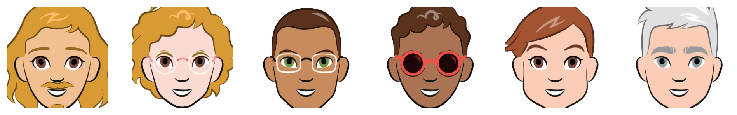

In [6]:
print ("Human Faces")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(6):
        file = np.random.choice(faces)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(660 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

print ("-"*80)
print ("Cartoon Faces")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(6):
        file = np.random.choice(cartoons)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img[120:380,120:380]
        plt.subplot(660 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Generator Model (Encdoer-Decoder architecture)

In [14]:
def make_generator():
    masked_image = tensorflow.keras.layers.Input(shape=(64, 64, 3))
    
    enc = masked_image
    
    #Encoder part
    enc = tensorflow.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(enc)
    enc = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(enc)
    enc = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(enc)
    
    enc = tensorflow.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(enc)
    enc = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(enc)
    enc = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(enc)
    
    enc = tensorflow.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(enc)
    enc = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(enc)
    enc = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(enc)
    
    enc = tensorflow.keras.layers.Conv2D(512, kernel_size=1, strides=2, padding='same')(enc)
    enc = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(enc)
    enc = tensorflow.keras.layers.Dropout(0.5)(enc)
    
    #Decoder part
    dec = enc
    
    dec = tensorflow.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(dec)
    dec = tensorflow.keras.layers.Activation('relu')(dec)
    dec = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(dec)
    
    dec = tensorflow.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(dec)
    dec = tensorflow.keras.layers.Activation('relu')(dec)
    dec = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(dec)
    
    dec = tensorflow.keras.layers.Conv2D(3, kernel_size=3, padding='same')(dec)
    
    missing_image = tensorflow.keras.layers.Activation('tanh')(dec)
    
    return masked_image, missing_image

masked_image, missing_image = make_generator()
generator_network = tensorflow.keras.models.Model(inputs=masked_image, outputs=missing_image)
generator_network.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 16, 16, 64)        256 

# Discriminator Network

In [15]:
def make_discriminator():
    input_image = tensorflow.keras.layers.Input(shape=(16, 16, 3))
    
    x = input_image
    
    x = tensorflow.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    
    x = tensorflow.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    
    x = tensorflow.keras.layers.Conv2D(256, kernel_size=3, padding='same')(x)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    
    x = tensorflow.keras.layers.Flatten()(x)
    
    real_vs_fake = tensorflow.keras.layers.Dense(1, activation='sigmoid')(x)
    
    return input_image, real_vs_fake

input_image, real_vs_fake = make_discriminator()
discriminator_network = tensorflow.keras.models.Model(inputs=input_image, outputs=real_vs_fake)
discriminator_network.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 16, 16, 3)]       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 64)          1792      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 4, 4, 128)         512 

In [16]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# Define  Context-Encoder

In [17]:
discriminator_network.trainable=False

g_output = generator_network(masked_image)
d_output = discriminator_network(g_output)

context_encoder = tensorflow.keras.models.Model(inputs = masked_image, outputs = [g_output, d_output])
context_encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
model_4 (Functional)         (None, 16, 16, 3)         826435    
_________________________________________________________________
model_5 (Functional)         (None, 1)                 376705    
Total params: 1,203,140
Trainable params: 825,603
Non-trainable params: 377,537
_________________________________________________________________


# Compiling Models

In [18]:
context_encoder.compile(loss=['mse', 'binary_crossentropy'], optimizer=adam_optimizer, loss_weights=[0.999, 0.001])

# Define Data Generators

In [43]:
def get_masked_images(images, mask_size=16):
    y1 = np.random.randint(0, images[0].shape[0] - mask_size, len(images))
    y2 = y1 + mask_size
    x1 = np.random.randint(0, images[0].shape[0] - mask_size, len(images))
    x2 = x1 + mask_size
    
    masked_imgs = np.empty_like(images)
    missing_parts = np.empty((len(images), mask_size, mask_size, 3))
    for i, img in enumerate(images):
        masked_img = img.copy()
        _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i]
        missing_parts[i] = masked_img[_y1:_y2, _x1:_x2, :].copy()
        masked_img[_y1:_y2, _x1:_x2, :] = 0
        masked_imgs[i] = masked_img

    return masked_imgs, missing_parts, (y1, y2, x1, x2) 

def get_training_samples(batch_size):
    random_files = np.random.choice(faces, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))
        images.append((img-127.5)/127.5)
    images = np.array(images)
    
    masked_imgs, missing_parts, _ = get_masked_images(images)
    return masked_imgs, missing_parts

def show_generator_results(generator_network):
    images = []
    for j in range(5):
        file = np.random.choice(faces)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))
        images.append((img-127.5)/127.5)
        
    masked_imgs, missing_parts, (y1s, y2s, x1s, x2s) = get_masked_images(images)

    predicted_missing_parts = generator_network.predict_on_batch(masked_imgs)
    
    print ('Masked Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(masked_imgs):
        plt.subplot(550 + 1 + j)
        plt.imshow((img+1.0)/2.0)
        plt.axis('off')
    plt.show()

    print ('Completed by Context Encoder')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        y1, y2, x1, x2 = y1s[j], y2s[j], x1s[j], x2s[j]
        filled_image = images[j].copy()
        filled_image[y1:y2,x1:x2,:] = predicted_missing_parts[j]
        plt.subplot(550 + 1 + j)
        plt.imshow((filled_image+1.0)/2.0)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()
    
    print ('Original Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(550 + 1 + j)
        plt.imshow((img+1.0)/2.0)
        plt.axis('off')
    plt.show()

# Training GAN

In [44]:
len(faces), len(cartoons)

(3400, 10000)

Masked Images


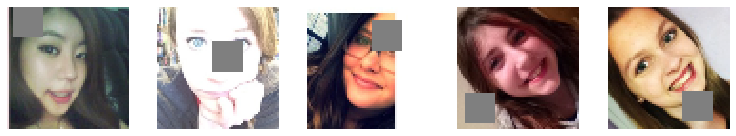

Completed by Context Encoder


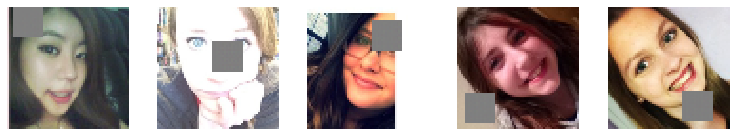

Original Images


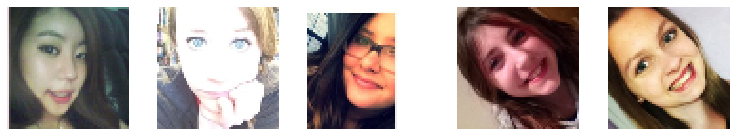

Epoch:0, Step:0, D-Loss:0.906, D-Acc:53.125, G-Loss:0.753


KeyboardInterrupt: 

In [46]:
epochs = 500
batch_size = 64
steps = 3400

for i in range(0, epochs):
    for j in range(steps): 
        if j%200 == 0:
            show_generator_results(generator_network) 

        masked_imgs, missing_parts = get_training_samples(batch_size)

        fake = np.zeros((batch_size, 1))
        real = np.ones((batch_size, 1))
        
        fake_missing_parts = generator_network(masked_imgs)
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d_real = discriminator_network.train_on_batch(missing_parts, real)
        loss_d_fake = discriminator_network.train_on_batch(fake_missing_parts, fake)
        
        loss_d = np.add(loss_d_real, loss_d_fake)/2.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        discriminator_network.trainable=False

        # Updating Generator weights
        loss_g = context_encoder.train_on_batch(masked_imgs,[missing_parts, real])
        
        if j%100 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g[0]))
            

In [35]:
%debug

> <ipython-input-32-ae67bbdb5527>(57)show_generator_results()
     55         y1, y2, x1, x2 = y1s[j], y2s[j], x1s[j], x2s[j]
     56         filled_image = images.copy()
---> 57         filled_image[y1:y2,x1:x2,:] = predicted_missing_parts[i,:,:,:]
     58         plt.subplot(550 + 1 + j)
     59         plt.imshow((filled_image+1.0)/2.0)

ipdb> predicted_missing_parts.shape
(5, 16, 16, 3)
ipdb> predicted_missing_parts[0].shape
(16, 16, 3)
ipdb> y1,y2,x1,x2
(27, 43, 34, 50)
ipdb> i
0
ipdb> Q
*** NameError: name 'Q' is not defined
ipdb> q


Masked Images


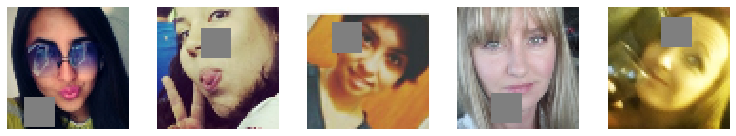

Completed by Context Encoder


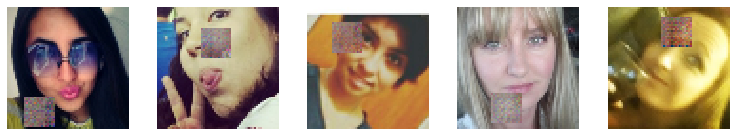

Original Images


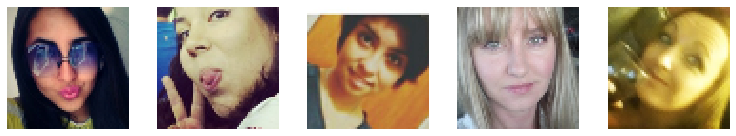

----------------------------------------------------------------------------------------------------
Masked Images


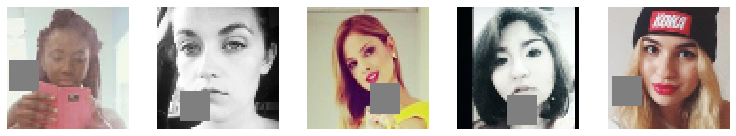

Completed by Context Encoder


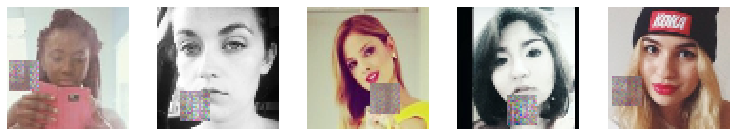

Original Images


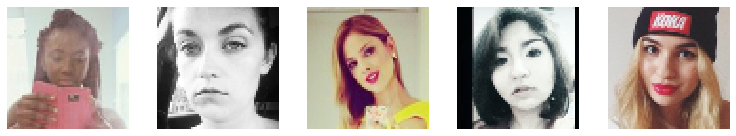

----------------------------------------------------------------------------------------------------
Masked Images


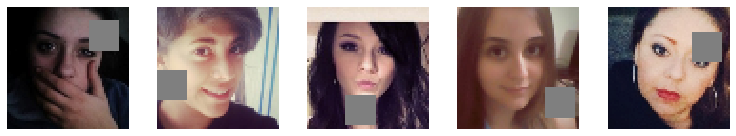

Completed by Context Encoder


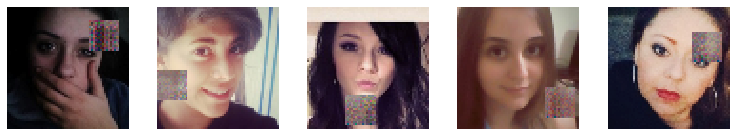

Original Images


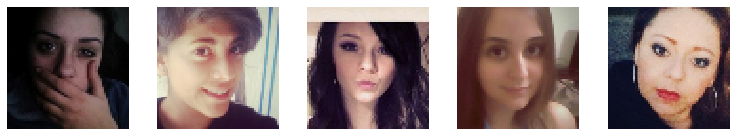

----------------------------------------------------------------------------------------------------


In [47]:
for i in range(3):
    show_generator_results(generator_network) 
    print ("-"*100)